In [1]:
# mount the google drive in your notebook in case you want to use Google Colab
# if you want to use your local machine, you don't need to run this cell instead, you need to download the data and load it locally
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#to import cv2 on your local machine, first run pip install opencv-python
import cv2

In [3]:
base_url= 'D:/Grad_dip/4.Applied Data Analysis/Assessment/Assignment-2/Data/'
train_df = pd.read_csv(base_url + 'trainset_students.csv')
train_df.head()

ID     Label  Label_Confidence
0  818021711  Positive            0.6715
1  911806503  Positive            0.6642
2  882035319  Negative            0.6683
3  880892525   Neutral            0.3360
4  828003448  Positive            1.0000

# EDA

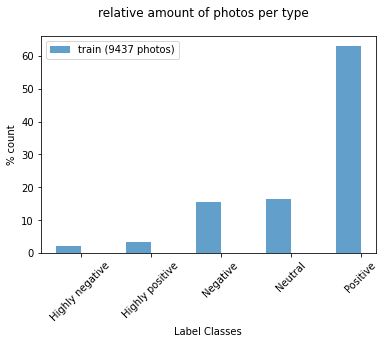

In [4]:
# let's see the label distribution
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('Label Classes')
    plt.ylabel(ylabel_text)

plt.suptitle('relative amount of photos per type')
plot_bar(train_df['Label'], loc='left')
plt.legend([
    'train ({0} photos)'.format(len(train_df['Label']))
]);

looks imbalanced right? you should know by now what that means! let's see some random images with their labels


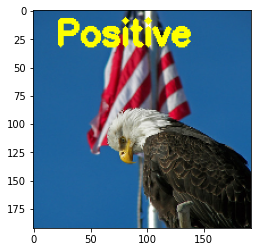

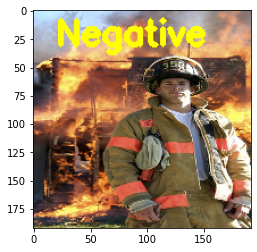

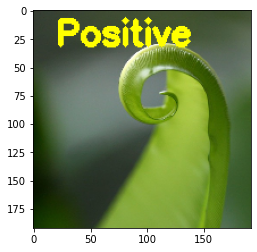

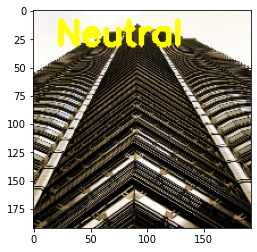

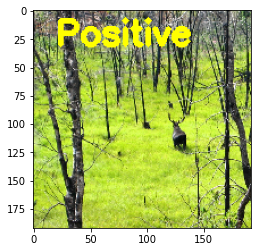

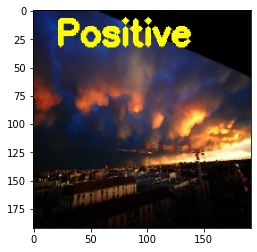

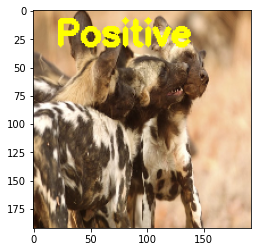

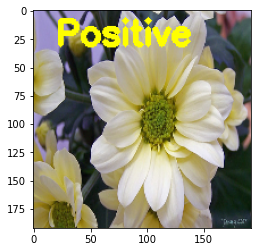

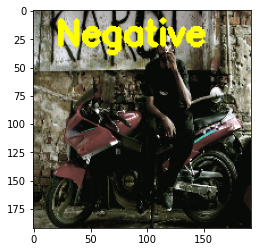

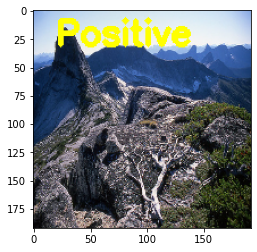

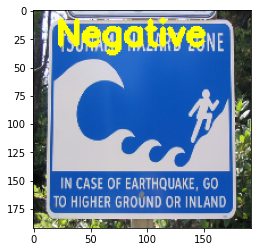

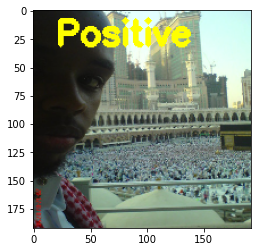

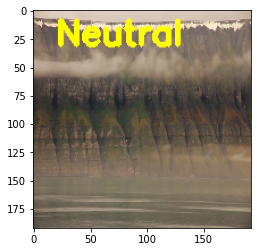

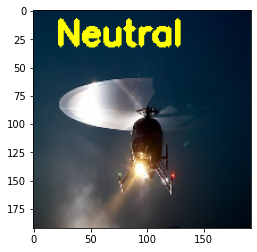

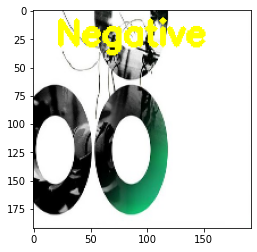

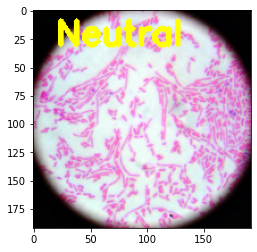

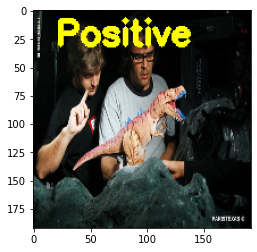

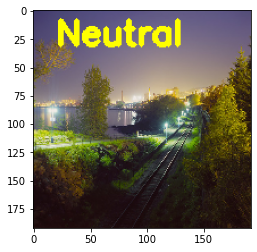

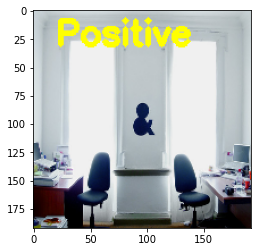

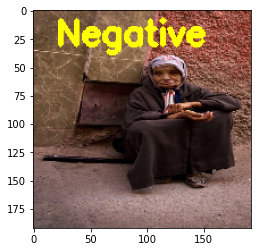

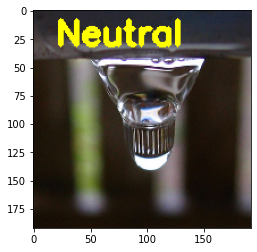

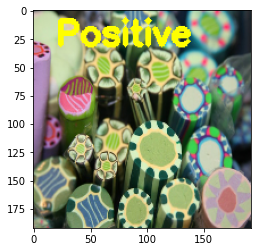

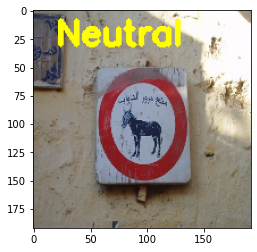

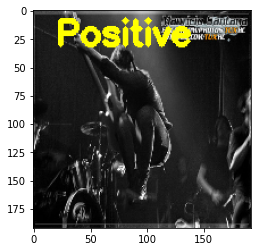

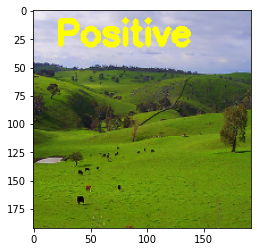

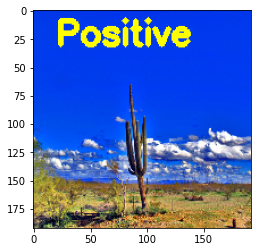

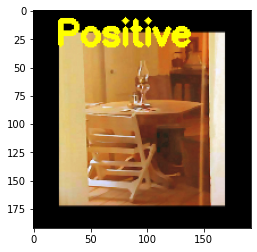

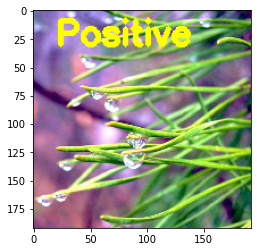

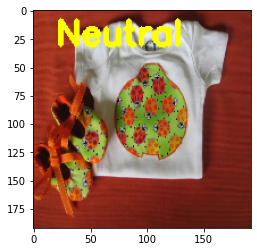

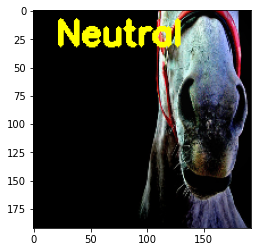

In [11]:
# show 30 random label on image
fixed_size = tuple((192, 192))
for i in np.random.randint(low=0, high = len(train_df), size=30):
    file = base_url + "images/" + str(train_df.iloc[i,0]) + ".jpg"
    #file= "images/" + str(train_df.iloc[i,0]) + ".jpg"
    image = cv2.imread(file)
    image = cv2.resize(image, fixed_size)
    cv2.putText(image, train_df.iloc[i,1], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)
    cv2.putText(image, str(train_df.iloc[i,2]), (320,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

Looks like positive images are very bright having widespread colour-combination. On the other hand,Negative images are in gray scale or black or red coloured. Neutral ones are mostly following a pattern.

In [ ]:
# Let's investigate the confidence level distribution for each class.

In [7]:
import plotly.express as px
df =train_df
fig = px.histogram(df, x="Label_Confidence", y="ID", color="Label", facet_col="Label")
fig.show()

We can hardly follow Label confidence distribution for highly positive and highly negative classes from the above facetted bar plot.
So, let's have a look individually only those two classes

(array([104.,   0.,  15.,  12.,  78.,  79.,   1.,   1.,   0.,  13.]),
 array([0.3338 , 0.40042, 0.46704, 0.53366, 0.60028, 0.6669 , 0.73352,
        0.80014, 0.86676, 0.93338, 1.     ]),
 <BarContainer object of 10 artists>)

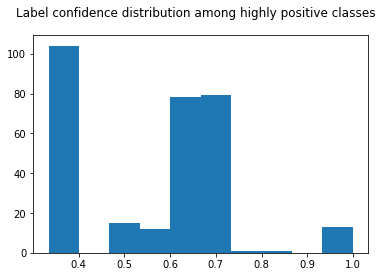

In [15]:
plt.suptitle('Label confidence distribution among highly positive classes')
plt.hist(train_df[train_df.Label=='Highly positive'].Label_Confidence)

(array([54.,  0., 14., 16., 47., 37.,  2.,  5.,  2., 11.]),
 array([0.3342 , 0.40078, 0.46736, 0.53394, 0.60052, 0.6671 , 0.73368,
        0.80026, 0.86684, 0.93342, 1.     ]),
 <BarContainer object of 10 artists>)

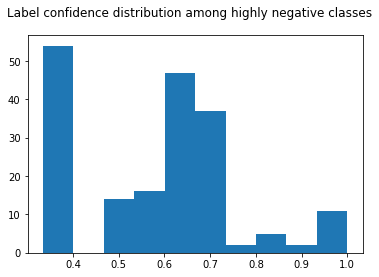

In [16]:
plt.suptitle('Label confidence distribution among highly negative classes')
plt.hist(train_df[train_df.Label=='Highly negative'].Label_Confidence)

In [17]:
train_df.iloc[i,2]

1.0

Some interesting observations right? I am not going to keep exploring but you probably should! Think about the color distributions in each class for example.

# Feature Extraction

Feature extraction is performed in two stages:

1) feature extrated from the provided features and 2) feature extracted from the pixels of the images

In [ ]:
#!pip install mahotas==1.4.11
#!pip install opencv-python

     |████████████████████████████████| 5.7 MB 8.2 MB/s 


In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from skimage.io import imread, imshow
from skimage import filters
from skimage.filters import prewitt_h,prewitt_v
import mahotas

import cv2
import os

## feature extractors

In [19]:
# feature-descriptor-1: Hu Moments
# here is more info about this feature
# https://learnopencv.com/shape-matching-using-hu-moments-c-python/
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [20]:
# feature-descriptor-2: Haralick Texture
# here is more info about this feature
# https://www.nature.com/articles/s41598-017-04151-4

def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

In [21]:
# feature-descriptor-3: Color Histogram
# here is more info about this feature
# https://en.wikipedia.org/wiki/Color_histogram
def fd_histogram(image, mask=None, bins = 8):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

In [24]:
def fd_pixel(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    pixel= np.reshape(image,150*150)
    return pixel

## convert all images to numeric features

In [25]:
# to convert the input image to a fixed size of (500, 500).
# this can take a while on Colab beacuse of the I/O time (around 30 minutes, I stopped it after 20!)
fixed_size = tuple((500, 500))

# empty lists to hold feature vectors and labels
global_features = []
labels = []
confidence = []

# loop over the images
for row in train_df.iterrows():
    # get the image file name
    file = base_url + "images/"  + str(row[1]['ID']) + ".jpg"

    # read the image and resize it to a fixed-size
    image = cv2.imread(file)
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image, bins = 8)

    ###################################
    # Concatenate global features
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
    # global_feature = np.hstack([fv_histogram, fv_hu_moments])

    # update the list of labels and feature vectors
    labels.append(row[1]['Label'])
    confidence.append(row[1]['Label_Confidence'])
    global_features.append(global_feature)

In [26]:
# to convert the input image to a fixed pixel size of (150, 150).

fixed_size = tuple((150, 150))

# empty lists to hold pixel vectors

pixel_feature_list =[]

# loop over the images
for row in train_df.iterrows():
    # get the image file name
    file = base_url + "images/"  + str(row[1]['ID']) + ".jpg"
    # read the image and resize it to a fixed-size
    image = cv2.imread(file)
    image = cv2.resize(image,fixed_size)
    fv_pixel       = fd_pixel(image)
    
    pixel_feature_list.append(fv_pixel)
    

In [30]:
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

# encode the target labels
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
print("[STATUS] training labels encoded...")

# scale features in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
rescaled_pixel = scaler.fit_transform(pixel_feature_list)
print("[STATUS] feature vector and pixel vector normalized...")

print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

[STATUS] feature vector size (9437, 532)
[STATUS] training Labels (9437,)
[STATUS] training labels encoded...
[STATUS] feature vector and pixel vector normalized...
[STATUS] target labels: [4 4 2 ... 4 0 4]
[STATUS] target labels shape: (9437,)


In [36]:
feature_data_train = pd.DataFrame(rescaled_features)
df_labels = pd.DataFrame(target)
df_labels.rename(columns = {0:'Label'}, inplace = True)
pixel_feature = pd.DataFrame(rescaled_pixel)

In [34]:
# Taking cubic value of for confidence to wight the higher value
df_conf = pd.DataFrame(train_df['Label_Confidence']**3)